In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
import itertools
import seaborn as sns

In [3]:
v = np.genfromtxt('MDA3_data/votes.txt')
votes = 2*(v-0.5)

In [4]:
masks = [1 << i for i in range(9)] 
words = np.array([[int((i & m)>0) for m in masks] for i in range(2**9)])
words = 2*(words - 0.5)

In [5]:
cov_v = (votes[:800].T @ votes[:800])
cor_v = cov_v/np.diag(cov_v)
pv_flat = cor_v[np.triu_indices(9,1)]

In [6]:
def probs(J):
    p=np.exp(np.sum((words @ J)*words,1)) # compute the not normalized probabilities
    return p / np.sum(p) # return normalized

In [7]:
def F(x):
    # this is the function to find the root of. 
#     as input get  the flattened upper triang of J
    J = np.zeros_like(cor_v) # "unflatten it"
    J[np.triu_indices(9,1)]=x # put input in the right place
    p = probs(J) # compute probabilities
    pv_th = (words.T * p) @ words #compute the model correlations with this given J
    return pv_th[np.triu_indices(9,1)] - pv_flat # return difference between model correlations and data correlations


In [88]:
# find root of F - here I'm using scipy.optimize but you can use whatever!
a = optimize.newton_krylov(F,np.zeros(36))
# convert result back to matrix form
J_star = np.zeros_like(cor_v)
J_star[np.triu_indices(9,1)]=a

In [99]:
np.save('3.6_J_star_part1',J_star)

In [112]:
J_star

array([[ 0.        ,  0.51759388,  0.39875535,  0.47064415, -0.17385993,
         0.32813727, -0.48993372, -0.25636634,  0.04771554],
       [ 0.        ,  0.        ,  0.72432874,  0.46334695, -0.15713358,
         0.05288833,  0.34832908,  0.131415  , -0.17420815],
       [ 0.        ,  0.        ,  0.        ,  0.30016292,  0.37475765,
         0.12473581, -0.1303218 ,  0.02564607,  0.15717958],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.6198586 ,
         0.08264835,  0.24688556, -0.04653639, -0.36213331],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.29650612,  0.40758778,  0.1189056 ,  0.2822742 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.60873196,  0.21041869,  0.28170892],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.35730754,  0.37971738],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7'),
 Text(0, 7.5, '8'),
 Text(0, 8.5, '9')]

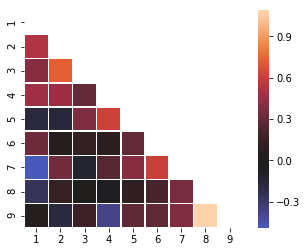

In [100]:
mask = np.triu(np.ones_like(J_star, dtype=bool))
heatmap = sns.heatmap(J_star.T, mask=mask, center=0, square=True, linewidths=.5)
heatmap.set_xticklabels(labels = range(1,10)) 
heatmap.set_yticklabels(labels = range(1,10)) 

In [101]:
P_train = probs(J_star)

In [102]:
test = votes[800:]
index = []
for i, word in enumerate(words):
    for j, word1 in enumerate(test):
        if tuple(word) == tuple(word1):
            if i in index: continue
            else: index.append(i)

In [103]:
likelihood = np.sum(np.log(P_train[index]))

In [104]:
likelihood

-219.8110891860576

#### Comparison of the models

In [105]:
means_model = np.sum(words.T * P_train, 1)
means_av = np.mean(votes[:800],0)

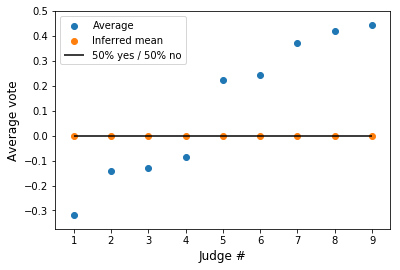

In [106]:
plt.scatter(range(1,10),means_av, label  = 'Average')
plt.scatter(range(1,10),means_model, label = 'Inferred mean')
plt.xticks(range(1,10))
plt.xlabel('Judge #', fontsize = 12)
plt.ylabel('Average vote', fontsize = 12)
plt.hlines(0, 1, 9, label = '50% yes / 50% no')
plt.legend()

In [107]:
w_cent = np.array(words - np.sum(words.T * P_train,1),copy=True)
cov = (P_train * w_cent.T) @ w_cent
sigma = np.sqrt(np.sum(w_cent.T * w_cent.T * P_train, 1)) 
cor = cov / np.outer(sigma, sigma)

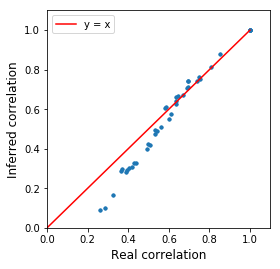

In [108]:
plt.figure(figsize = (4,4))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), c = 'red', label = 'y = x')
plt.scatter(np.corrcoef(votes[:800].T), cor, marker = '.')
plt.ylabel('Inferred correlation', fontsize = 12)
#plt.scatter(np.corrcoef(votes[:800].T), cor_v, marker = '.', label = 'cor')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xlabel('Real correlation', fontsize = 12)
plt.legend()